The center of the enclosing circle is at coordinates: (1133, 1133)
X (mm)	Y (mm)	d (mm)	2θ (degrees)	Intensity
[[0.00000000e+00 0.00000000e+00 2.40310255e+02 6.74064024e+01
  6.37500000e+01]
 [0.00000000e+00 1.49977944e-01 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [0.00000000e+00 2.99955889e-01 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 ...
 [3.39850022e+02 3.39550066e+02 2.40098248e+02 6.73884594e+01
  6.37500000e+01]
 [3.39850022e+02 3.39700044e+02 2.40204228e+02 6.73974323e+01
  6.37500000e+01]
 [3.39850022e+02 3.39850022e+02 2.40310255e+02 6.74064024e+01
  6.37500000e+01]]


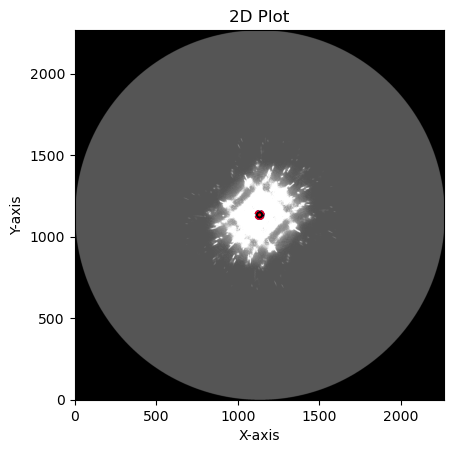

In [7]:
## Image Plate Diffraction System ##

## Image Analysis q-2theta (Version 1.2) ##

## Empa, Center for X-ray Analytics, D.Sapalidis, St. Gallen, Switzerland, 22.12.2023 ##

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image

# Define the center of the imaging plate by intensity variations 

class ImageClicker:
    def __init__(self, image_path, outer_radius_mm):
        self.image = np.array(Image.open(image_path))
        self.grayscale_image = np.mean(self.image, axis=2)
        self.fig, self.ax = plt.subplots()
        self.im = self.ax.imshow(self.grayscale_image, cmap='gray', origin='lower')
        self.coords = []

        self.ax.set_title('2D Plot')
        self.ax.set_xlabel('X-axis')
        self.ax.set_ylabel('Y-axis')
        
        self.outer_radius_mm = outer_radius_mm

        # Find the enclosing circle around points with minimum intensity
        self.center, radius = self.find_center_and_enclosing_circle()
        print(f'The center of the enclosing circle is at coordinates: ({self.center[0]}, {self.center[1]})')

        # Display the center and circles on the plot
        self.draw_circle(self.center[0], self.center[1], radius)

        # Draw the red disk on the plot
        red_disk_patch = patches.Circle((self.center[0], self.center[1]), radius, color='red', fill=False, linestyle='dashed')
        self.ax.add_patch(red_disk_patch)

    def find_center_and_enclosing_circle(self):
        # Define the region of interest (ROI)
        x_max, y_max = self.grayscale_image.shape
        roi_x_start, roi_x_end = x_max // 4, int(x_max / 1.5)
        roi_y_start, roi_y_end = y_max // 4, int(y_max / 1.5)

        # Extract the ROI from the grayscale image
        roi = self.grayscale_image[roi_x_start:roi_x_end, roi_y_start:roi_y_end]

        # Find the coordinates of points with minimum intensity in the ROI
        min_intensity_coords = np.argwhere(roi == np.min(roi))

        # Shift the coordinates back to the original image coordinates
        min_intensity_coords[:, 0] += roi_x_start
        min_intensity_coords[:, 1] += roi_y_start

        # Find the enclosing circle
        _, radius = cv2.minEnclosingCircle(min_intensity_coords.astype(np.float32))
        return tuple(map(int, min_intensity_coords.mean(axis=0))), int(radius)


    def draw_circle(self, center_x, center_y, radius):
        # Display the center and circle on the plot
        center_marker = plt.Circle((center_x, center_y), 5, color='red', fill=True)
        disk_patch = patches.Circle((center_x, center_y), radius, color='blue', fill=False, linestyle='dashed')

        self.ax.add_patch(center_marker)
        self.ax.add_patch(disk_patch)

# Convert the 2D diagram from pixels to mm and store for each pixel the 2-theta and d information

class ImageProcessor:
    
    def __init__(self, clicker, wavelength, sample_detector_distance):
        self.clicker = clicker
        self.wavelength = wavelength
        self.sample_detector_distance = sample_detector_distance
        self.process_image()

    def process_image(self):
        mm_per_pixel_x = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[1]
        mm_per_pixel_y = (2 * self.clicker.outer_radius_mm) / self.clicker.grayscale_image.shape[0]

        mm_intensity_array = np.zeros_like(self.clicker.grayscale_image, dtype=float)
        mm_d_theta_intensity_array = []

        for x, row in enumerate(self.clicker.grayscale_image):
            for y, intensity in enumerate(row):
                radius = np.sqrt((x - self.clicker.center[0]) ** 2 + (y - self.clicker.center[1]) ** 2)
                mm_x = x * mm_per_pixel_x
                mm_y = y * mm_per_pixel_y

                # d distance calculation from center
                d = radius * (mm_per_pixel_x + mm_per_pixel_y)/2

                # 2 theta calculation
                theta = np.degrees(np.arctan(d / self.sample_detector_distance))

                # Save the data
                mm_d_theta_intensity_array.append([mm_x, mm_y, d, theta, intensity])

        
        mm_d_theta_intensity_array = np.array(mm_d_theta_intensity_array)

        # Print the matrix
        print("X (mm)\tY (mm)\td (mm)\t2θ (degrees)\tIntensity")
        print(mm_d_theta_intensity_array)

if __name__ == "__main__":
    
    # User's input - Type the parameters of the experiment and the path of the image
    main_image_path = 'C:/Users/Dimitris/Desktop/IPDS Images Results/DCSQI_annealed_40mm_240min_om0_ph10rpm_201223.tif'
    outer_radius_mm = 170
    wavelength = 0.71  #  Ångströms
    sample_detector_distance = 100  #  mm

    clicker = ImageClicker(main_image_path, outer_radius_mm)
    processor = ImageProcessor(clicker, wavelength, sample_detector_distance)
